# Analysis of Machine Learning Models on the Effect of COVID-19 on People with Multiple Sclerosis

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the dataset

In [3]:
df = pd.read_csv('GDSI_OpenDataset_Final.csv')

### Data Preprocessing and Formatting

In [4]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_encoded = encoder.fit_transform(df[categorical_cols])

encoded_features = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_features)

cleaned_df = pd.concat([df[numeric_cols], encoded_df], axis=1)

### Scaling Features and Performing PCA

In [5]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cleaned_df)

pca = PCA(n_components=0.95) 
principal_components = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=[f"PC{i + 1}" for i in range(principal_components.shape[1])])

original_target = df['covid19_outcome_recovered']
filtered_target = original_target[original_target != 'not_applicable']
encoded_target = (filtered_target == 'yes').astype(int)

filtered_pca_df = pca_df.loc[filtered_target.index]

### Splitting Data and Applying SMOTE

In [6]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    filtered_pca_df, encoded_target, test_size=0.2, random_state=42
)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_filtered, y_train_filtered)

### Defining Models and Hyperparameter Grids

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network (MLPClassifier)": MLPClassifier(max_iter=1000, early_stopping=True, validation_fraction=0.1),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
}

param_grids = {
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    "Support Vector Machine": {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "K-Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "Neural Network (MLPClassifier)": {'hidden_layer_sizes': [(50,), (100,), (100, 50)]},
    "XGBoost": {'n_estimators': [50, 100, 200]}
}

### Hyperparameter Tuning and Best Models Selection

In [8]:
best_models = {}

for model_name, param_grid in param_grids.items():
    model = models[model_name]
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_  
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validated score: {grid_search.best_score_:.4f}")

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'saga'}
Best cross-validated score: 0.9542
Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Best cross-validated score: 0.9667
Best parameters for Support Vector Machine: {'C': 0.01, 'kernel': 'linear'}
Best cross-validated score: 0.9708
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3}
Best cross-validated score: 0.5667
Best parameters for Neural Network (MLPClassifier): {'hidden_layer_sizes': (100, 50)}
Best cross-validated score: 0.5625
Best parameters for XGBoost: {'n_estimators': 50}
Best cross-validated score: 0.9333


### Model Evaluation with ROC Curves and Confusion Matrices

Logistic Regression Accuracy: 0.98
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.97      1.00      0.99        36

    accuracy                           0.98        50
   macro avg       0.99      0.96      0.97        50
weighted avg       0.98      0.98      0.98        50
Random Forest Accuracy: 0.98
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.97      1.00      0.99        36

    accuracy                           0.98        50
   macro avg       0.99      0.96      0.97        50
weighted avg       0.98      0.98      0.98        50
Support Vector Machine Accuracy: 0.98
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.97      1.00      0.99        36

    accuracy                           0.98        50
   macro avg       0.99     

C:\Users\DELL\Desktop\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\Desktop\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\Desktop\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

K-Nearest Neighbors Accuracy: 0.28
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        14
           1       0.00      0.00      0.00        36

    accuracy                           0.28        50
   macro avg       0.14      0.50      0.22        50
weighted avg       0.08      0.28      0.12        50
Neural Network (MLPClassifier) Accuracy: 0.46
              precision    recall  f1-score   support

           0       0.26      0.50      0.34        14
           1       0.70      0.44      0.54        36

    accuracy                           0.46        50
   macro avg       0.48      0.47      0.44        50
weighted avg       0.57      0.46      0.49        50
XGBoost Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.94      0.97        36

    accuracy                           0.96        50
   macro avg       0.94   

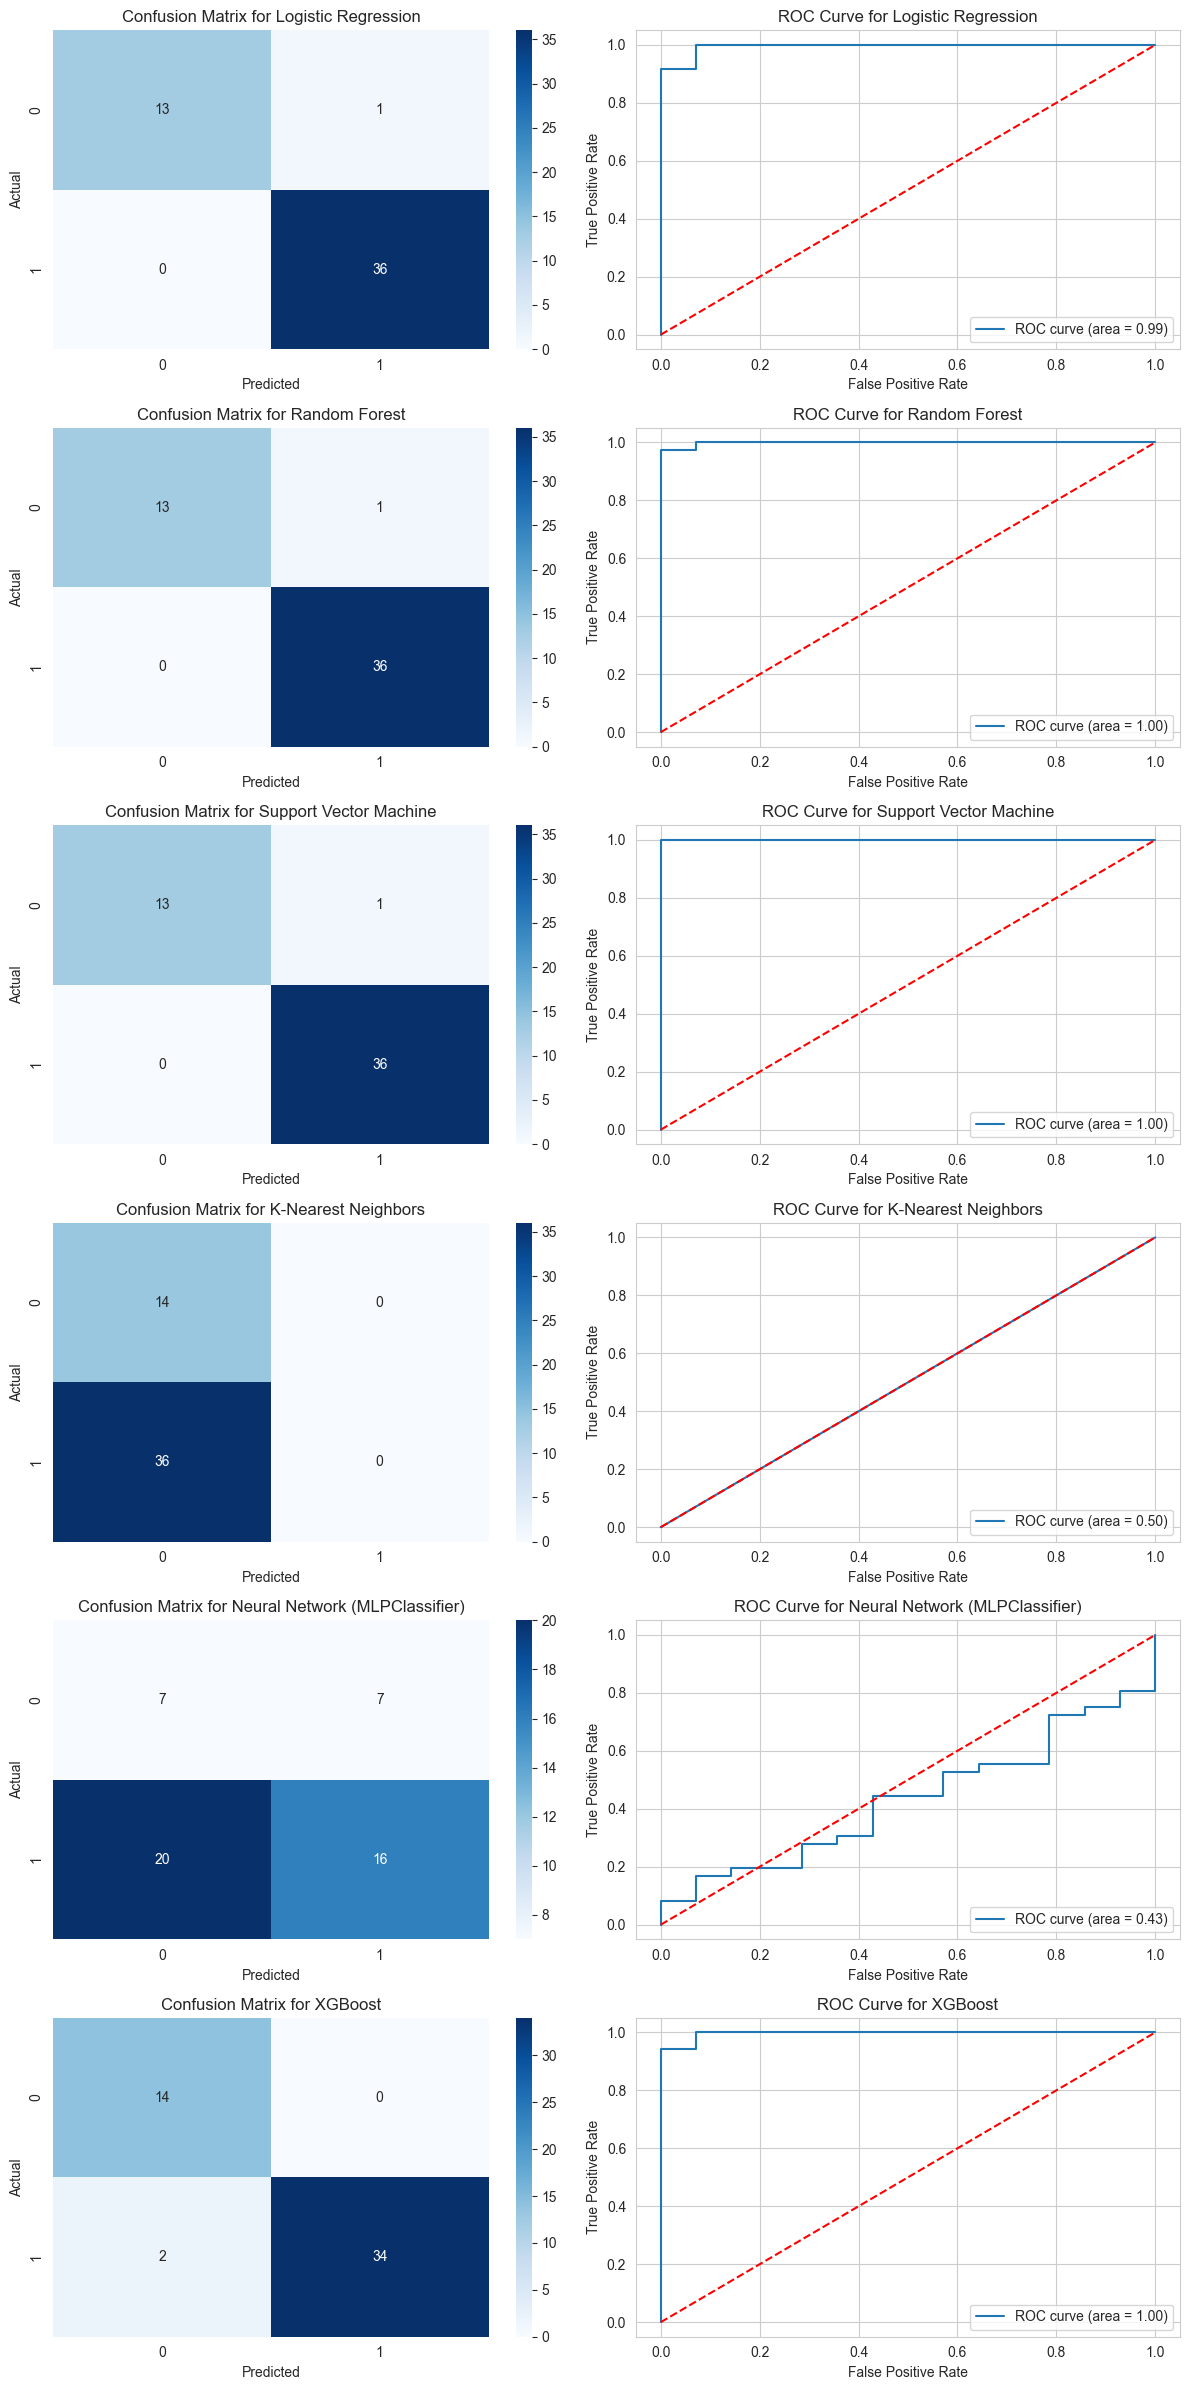

In [11]:
num_models = len(best_models)


fig, axes = plt.subplots(num_models, 2, figsize=(12, 4 * num_models))


for i, (model_name, model) in enumerate(best_models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_filtered)

    accuracy = accuracy_score(y_test_filtered, y_pred)
    class_report = classification_report(y_test_filtered, y_pred)
    
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(class_report)

    cm = confusion_matrix(y_test_filtered, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0])
    axes[i, 0].set_title(f'Confusion Matrix for {model_name}')
    axes[i, 0].set_xlabel('Predicted')
    axes[i, 0].set_ylabel('Actual')

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_filtered)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_filtered, y_prob)
        roc_auc = auc(fpr, tpr)

        axes[i, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[i, 1].plot([0, 1], [0, 1], 'r--')  
        axes[i, 1].set_title(f'ROC Curve for {model_name}')
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].legend(loc='lower right')


plt.tight_layout()

plt.show()


### Analyzing Learning Curves for Each Model

Logistic Regression - Training Accuracy: 1.00, Test Accuracy: 0.98
Random Forest - Training Accuracy: 1.00, Test Accuracy: 0.98
Support Vector Machine - Training Accuracy: 1.00, Test Accuracy: 0.98
K-Nearest Neighbors - Training Accuracy: 0.99, Test Accuracy: 0.28
Neural Network (MLPClassifier) - Training Accuracy: 0.97, Test Accuracy: 0.48
XGBoost - Training Accuracy: 1.00, Test Accuracy: 0.96


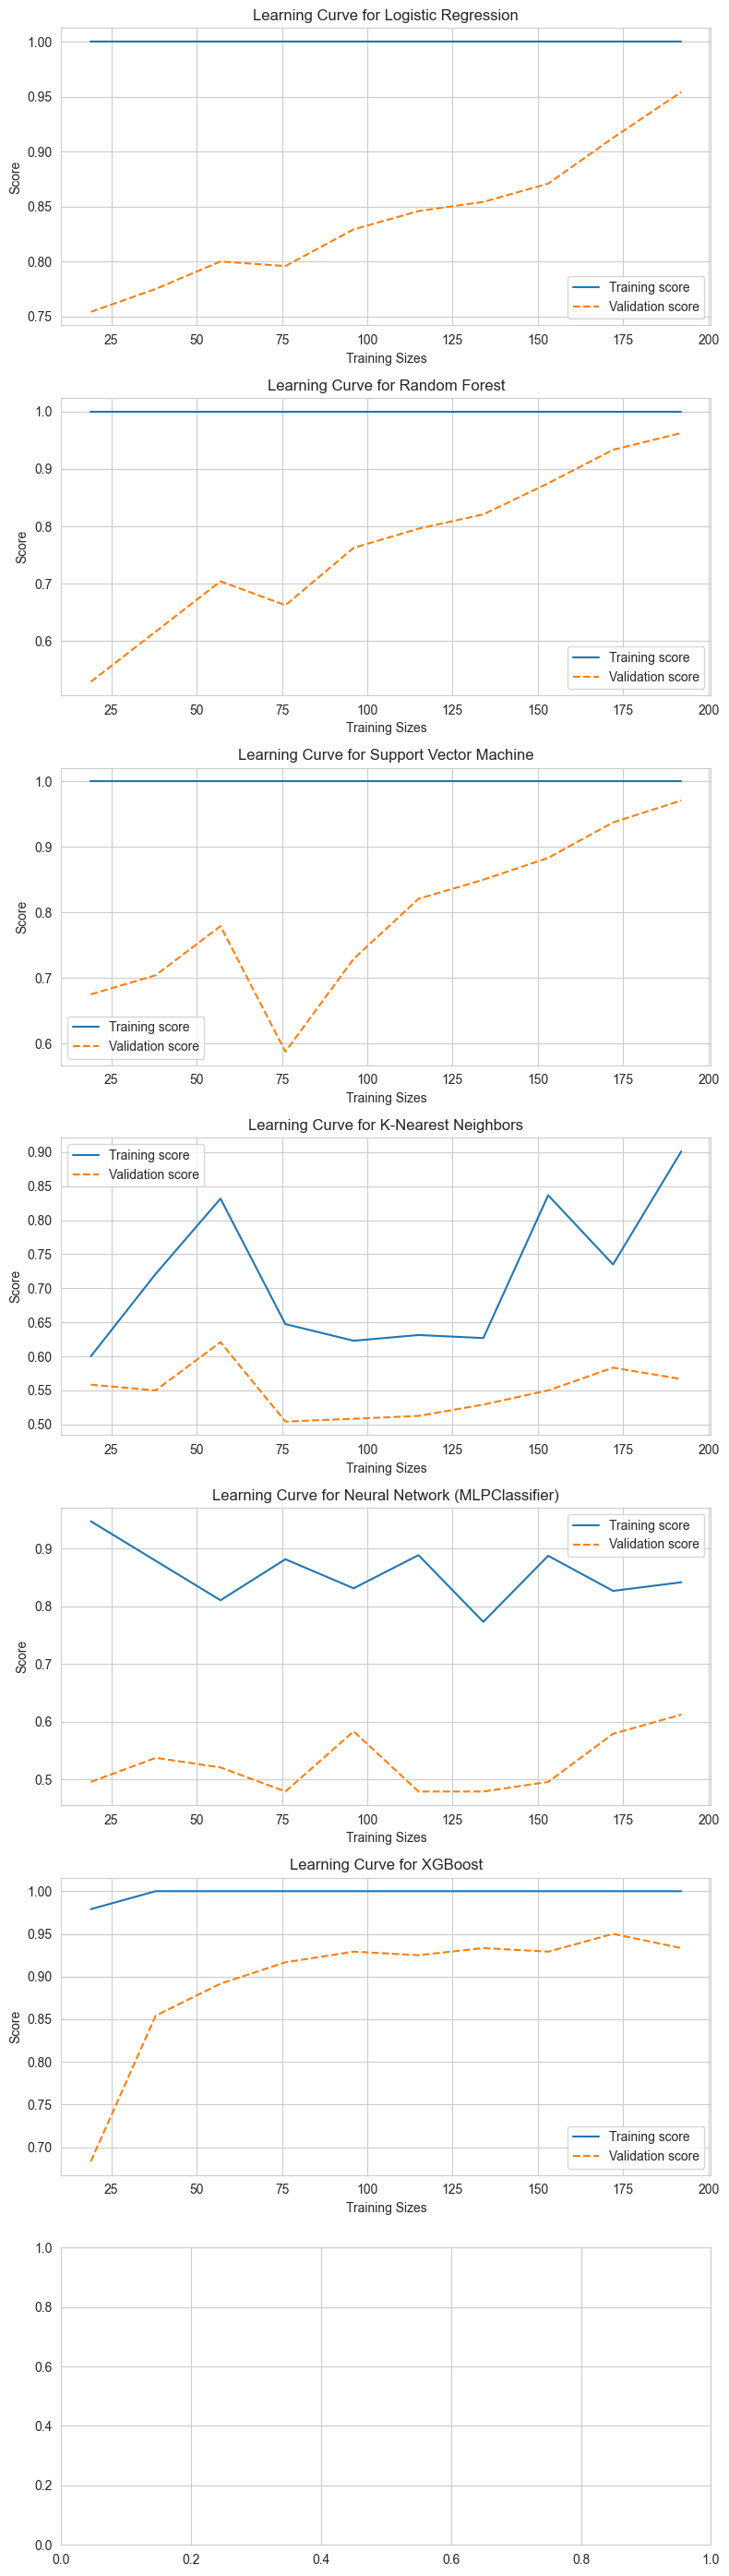

In [12]:
from sklearn.model_selection import learning_curve


num_models = len(models)
fig, axes = plt.subplots(num_models, 1, figsize=(8, 4 * num_models))

for ax, (model_name, model) in zip(axes, best_models.items()):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test_filtered, y_test_filtered)

    print(f"{model_name} - Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    ax.plot(train_sizes, train_scores_mean, label="Training score")
    ax.plot(train_sizes, test_scores_mean, '--', label="Validation score")
    ax.set_title(f'Learning Curve for {model_name}')
    ax.set_xlabel('Training Sizes')
    ax.set_ylabel('Score')
    ax.legend(loc='best')


plt.tight_layout()

plt.show()


### Predicting Outcomes for a New Data Point Using Trained Models

Predictions for the new data point:
Logistic Regression: Outcome = yes, Probability (yes) = 0.7498714087646886
Random Forest: Outcome = yes, Probability (yes) = 0.56
Support Vector Machine: Outcome = yes, Probability (yes) = 0.8568265739147487
K-Nearest Neighbors: Outcome = no, Probability (yes) = 0.3333333333333333
Neural Network (MLPClassifier): Outcome = yes, Probability (yes) = 0.5932432372898292
XGBoost: Outcome = no, Probability (yes) = 0.12537316977977753


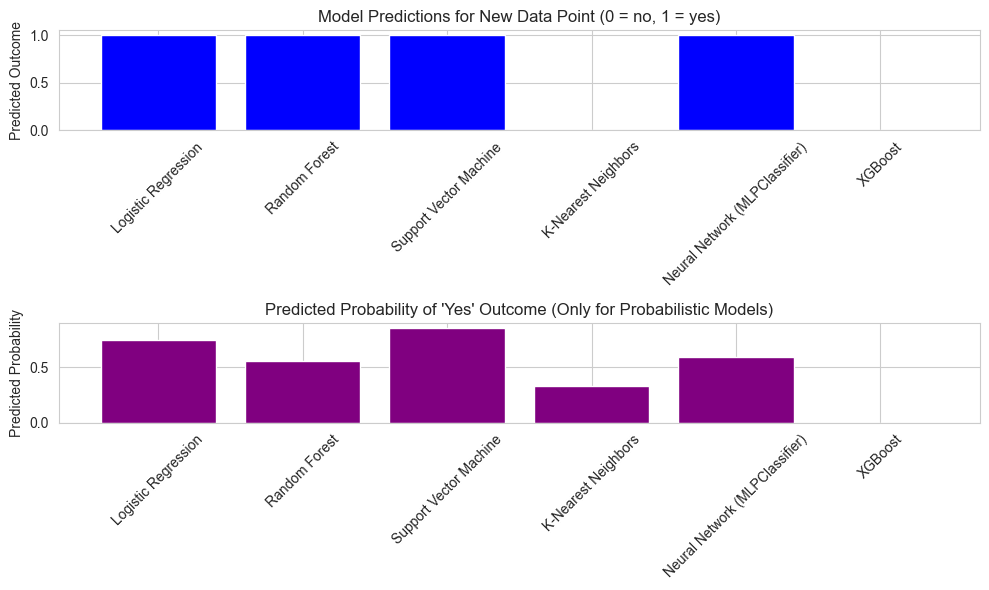

In [13]:
new_data_point = pd.DataFrame(np.mean(filtered_pca_df, axis=0).values.reshape(1, -1), columns=filtered_pca_df.columns)


new_data_predictions = {}


for model_name, model in best_models.items():
    predicted_outcome = model.predict(new_data_point)
    
    if hasattr(model, "predict_proba"):
        predicted_probability = model.predict_proba(new_data_point)
        predicted_prob_yes = predicted_probability[0][1] 
    else:
        predicted_prob_yes = "Not available"

    outcome_mapping = {0: "no", 1: "yes"}
    predicted_outcome_str = outcome_mapping[predicted_outcome[0]]
    new_data_predictions[model_name] = {
        "Predicted Outcome": predicted_outcome_str,
        "Predicted Probability (yes)": predicted_prob_yes
    }

print("Predictions for the new data point:")
for model_name, prediction in new_data_predictions.items():
    print(f"{model_name}: Outcome = {prediction['Predicted Outcome']}, Probability (yes) = {prediction['Predicted Probability (yes)']}") 

model_names = list(new_data_predictions.keys())
outcomes = [1 if prediction["Predicted Outcome"] == "yes" else 0 for prediction in new_data_predictions.values()]
probabilities = [
    prediction["Predicted Probability (yes)"] if isinstance(prediction["Predicted Probability (yes)"], float) else None 
    for prediction in new_data_predictions.values()
]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(model_names, outcomes, color=['blue' if outcome == 1 else 'grey' for outcome in outcomes])
plt.title("Model Predictions for New Data Point (0 = no, 1 = yes)")
plt.ylabel("Predicted Outcome")
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
plt.bar(model_names, [p if p is not None else 0 for p in probabilities], color='purple')
plt.title("Predicted Probability of 'Yes' Outcome ")
plt.ylabel("Predicted Probability")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()